
# Домашнее задание 2. Поисковая система для документов

**Модуль 2. Классический поиск и рекуррентные архитектуры**

**ФИО студента: Кузнецов Кирилл Игоревич**

**Дата выполнения: 17 сентября 2025**

## Описание задания

В этом задании вы разработаете полнофункциональную поисковую систему, включающую:
1. **Предобработку корпуса.**
2. **BM25.**
3. **Векторный поиск** — на основе эмбеддингов.
4. **Гибридный поиск** — комбинация BM25 и векторного поиска.
5. **Выбор метрики и оценку качества** — для конкретной задачи.

Дополнение от выполняющего: Поменял тестовые запросы на более релевантные для корпуса что бы обеспечить более адекватную оценку поисковой выдачи
---

## Установка и импорт библиотек

In [1]:
# # Установка необходимых библиотек
# !pip install sentence-transformers
# !pip install faiss-cpu
# !pip install rank-bm25  # для сравнения
# !pip install pymorphy3 pymorphy3-dicts-ru
# !pip install tqdm
# !pip install matplotlib seaborn
# !pip install pandas numpy

In [2]:
import pathlib
import re
import math
import time
from typing import List, Dict, Tuple, Optional, Set
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

# Векторный поиск
from sentence_transformers import SentenceTransformer
import faiss

# BM25
from rank_bm25 import BM25Okapi

# Создание директорий
for dir_name in ['data', 'indices', 'models', 'results', 'tests']:
    pathlib.Path(dir_name).mkdir(exist_ok=True)

# Загрузка NLTK ресурсов
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()


---

## Часть 1. Подготовка данных

1. Загрузите и изучите предложенный датасет.  
2. Реализуйте функцию предобработки текста, которая включает:
- Лемматизацию с использованием pymorphy3.
- Удаление стоп-слов и пунктуации.  
3. Обработайте весь корпус документов и сохраните результат для последующих шагов.  


In [3]:
from datasets import load_dataset

# Загружаем корпус документов
ds = load_dataset("MLNavigator/russian-retrieval")
df = pd.DataFrame(ds['train'])
questions_df = df[['text','q']]


# Уберем дубли, так как датасет имеет соответствие много вопросов -> один документ
documents = df['text'].drop_duplicates().to_list()


Статистика корпуса:
Средняя длина документа: 100.6 слов
Медианная длина: 91.0 слов
Мин/Макс: 41/1041 слов


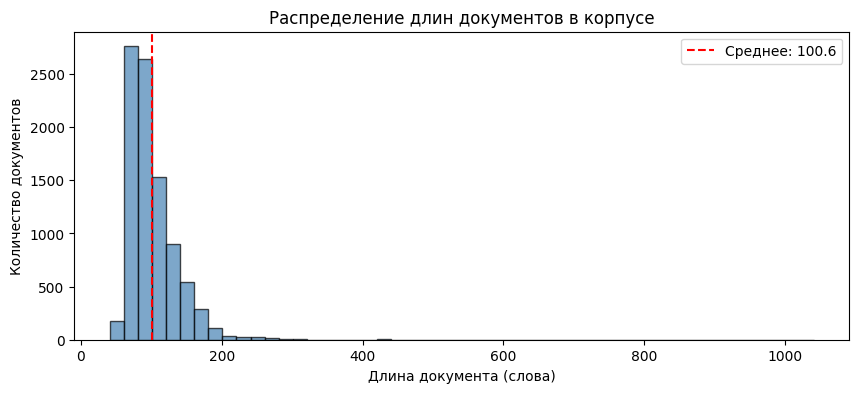

In [4]:
# Базовая статистика
doc_lengths = [len(doc.split()) for doc in documents]
print(f"\nСтатистика корпуса:")
print(f"Средняя длина документа: {np.mean(doc_lengths):.1f} слов")
print(f"Медианная длина: {np.median(doc_lengths):.1f} слов")
print(f"Мин/Макс: {min(doc_lengths)}/{max(doc_lengths)} слов")

# Визуализация распределения длин
plt.figure(figsize=(10, 4))
plt.hist(doc_lengths, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Длина документа (слова)')
plt.ylabel('Количество документов')
plt.title('Распределение длин документов в корпусе')
plt.axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Среднее: {np.mean(doc_lengths):.1f}')
plt.legend()
plt.show()

In [5]:
class TextPreprocessor:
    """
    Приводит текст к чистому, нормализованному виду:
    - Удаляет HTML, ссылки, пунктуацию
    - Переводит в нижний регистр
    - Убирает стоп-слова
    - Лемматизирует (приводит к начальной форме)
    - Отбрасывает короткие слова (<3 символов)
    """

    def __init__(self, use_lemmatization: bool = True, remove_stopwords: bool = True):
        self.use_lemmatization = use_lemmatization
        self.remove_stopwords = remove_stopwords
        self.morph = pymorphy3.MorphAnalyzer()
        self.stop_words = set(stopwords.words('russian'))

    def preprocess(self, text: str) -> List[str]:
        # 1. Очистка текста
        text = text.lower()
        text = re.sub(r'<.*?>', ' ', text)        # Удаляем HTML-теги
        text = re.sub(r'http\S+', ' ', text)      # Удаляем ссылки
        text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)  # Только буквы, цифры, пробелы
        text = re.sub(r'\s+', ' ', text).strip()  # Нормализуем пробелы

        if not text:
            return []

        # 2. Токенизация
        tokens = text.split()

        # 3. Удаление стоп-слов
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]

        # 4. Лемматизация
        if self.use_lemmatization:
            tokens = [self.morph.parse(t)[0].normal_form for t in tokens]

        # 5. Фильтрация коротких слов
        tokens = [t for t in tokens if len(t) >= 3]

        return tokens


# Создаём предобработчик и обрабатываем весь корпус
preprocessor = TextPreprocessor(use_lemmatization=True, remove_stopwords=True)

print("Предобработка корпуса...")
tokenized_documents = [
    preprocessor.preprocess(doc) for doc in tqdm(documents)
]

# Статистика после обработки
vocabulary = {token for doc in tokenized_documents for token in doc}
avg_tokens_per_doc = np.mean([len(doc) for doc in tokenized_documents])

print(f"\nРазмер словаря: {len(vocabulary)} уникальных слов")
print(f"Средняя длина документа после обработки: {avg_tokens_per_doc:.1f} токенов")

Предобработка корпуса...


  0%|          | 0/9076 [00:00<?, ?it/s]


Размер словаря: 59223 уникальных слов
Средняя длина документа после обработки: 73.9 токенов


---

## Часть 2. Реализация BM25

1. Постройте инвертированный индекс для корпуса. Индекс должен содержать частоту термина в документе (TF) и документную частоту (DF).
2. Реализуйте функцию поиска BM25 с нуля. Формула для ранжирования:

$score(D, Q) = Σ IDF(qi) * (f(qi, D) * (k1 + 1)) / (f(qi, D) + k1 * (1 - b + b * |D| / avgdl))$

3. Проведите оптимизацию гиперпараметра k1, чтобы улучшить качество поиска.

In [6]:
class InvertedIndex:
    """
    Хранит:
    - Для каждого термина: список документов, где он встречается + частота + позиции
    - Длины всех документов
    - Общую статистику (средняя длина, число документов и т.д.)
    """

    def __init__(self):
        # term - [{'doc_id', 'freq', 'positions'}, ...]
        self.term_to_postings = defaultdict(list)
        self.doc_lengths = {}                      # doc_id - длина в токенах
        # term - сколько документов содержат термин
        self.doc_freq = defaultdict(int)
        self.total_docs = 0
        self.avg_doc_len = 0.0

    def add_document(self, doc_id: int, tokens: List[str]):
        """Добавляет один документ в индекс."""
        self.doc_lengths[doc_id] = len(tokens)
        self.total_docs += 1

        # Считаем частоты и позиции
        term_freq = Counter(tokens)
        term_positions = defaultdict(list)
        for pos, term in enumerate(tokens):
            term_positions[term].append(pos)

        # Обновляем индекс и частоту документов
        for term in term_freq:
            self.term_to_postings[term].append({
                'doc_id': doc_id,
                'freq': term_freq[term],
                'positions': term_positions[term]
            })
            self.doc_freq[term] += 1

    def build(self, tokenized_docs: List[List[str]]):
        """Строит индекс для всего корпуса."""
        print("Построение инвертированного индекса...")
        for doc_id, tokens in enumerate(tqdm(tokenized_docs)):
            self.add_document(doc_id, tokens)

        self.avg_doc_len = sum(self.doc_lengths.values()
                               ) / len(self.doc_lengths)
        print(f"Индекс готов: {len(self.term_to_postings)} терминов, "
              f"{self.total_docs} документов, "
              f"средняя длина: {self.avg_doc_len:.2f} токенов")

    def get_postings(self, term: str) -> List[Dict]:
        return self.term_to_postings.get(term, [])

    def get_stats(self) -> Dict:
        posting_sizes = [len(p) for p in self.term_to_postings.values()]
        return {
            'total_terms': len(self.term_to_postings),
            'total_docs': self.total_docs,
            'avg_doc_length': self.avg_doc_len,
            'avg_posting_size': np.mean(posting_sizes) if posting_sizes else 0,
            'max_posting_size': max(posting_sizes) if posting_sizes else 0
        }


# Создание и построение инвертированного индекса на основе предварительно токенизированных документов
index = InvertedIndex()
index.build(tokenized_documents)

stats = index.get_stats()
print("Статистика:")
for key, value in stats.items():
    print(f"{key}: {value}")

Построение инвертированного индекса...


  0%|          | 0/9076 [00:00<?, ?it/s]

Индекс готов: 59223 терминов, 9076 документов, средняя длина: 73.86 токенов
Статистика:
total_terms: 59223
total_docs: 9076
avg_doc_length: 73.86073159982371
avg_posting_size: 9.09006635935363
max_posting_size: 4074


In [7]:
class BM25:
    """
    Реализует алгоритм BM25 по формуле:
    score(D, Q) = Σ IDF(q) * [f(q,D) * (k1 + 1)] / [f(q,D) + k1 * (1 - b + b * |D| / avgdl)]
    """

    def __init__(self, index: InvertedIndex, k1: float = 1.2, b: float = 0.75):
        self.index = index
        self.k1 = k1
        self.b = b
        self.idf_cache = {}

    def _idf(self, term: str) -> float:
        """Вычисляет IDF с кэшированием."""
        if term in self.idf_cache:
            return self.idf_cache[term]

        N = self.index.total_docs
        df = self.index.doc_freq.get(term, 0)

        if df == 0:
            idf = 0.0
        else:
            idf = math.log((N - df + 0.5) / (df + 0.5) + 1)

        self.idf_cache[term] = idf
        return idf

    def _score_document(self, query_tokens: List[str], doc_id: int) -> float:
        """Считает BM25-скор для одного документа."""
        doc_len = self.index.doc_lengths.get(doc_id, 0)
        if doc_len == 0:
            return 0.0

        # Нормализация длины документа
        norm_len = 1 - self.b + self.b * (doc_len / self.index.avg_doc_len)

        # Частоты терминов запроса в документе
        term_freq_in_doc = {}
        for term in set(query_tokens):
            for posting in self.index.get_postings(term):
                if posting['doc_id'] == doc_id:
                    term_freq_in_doc[term] = posting['freq']
                    break

        # Суммируем вклад каждого термина
        total_score = 0.0
        for term in set(query_tokens):
            tf = term_freq_in_doc.get(term, 0)
            if tf == 0:
                continue

            idf = self._idf(term)
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * norm_len
            total_score += idf * (numerator / denominator)

        return total_score

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Возвращает top-k документов по релевантности запросу."""
        query_tokens = preprocessor.preprocess(query)
        if not query_tokens:
            return []

        # Собираем кандидатов: все документы, содержащие хотя бы один термин
        candidate_doc_ids = set()
        for term in query_tokens:
            for posting in self.index.get_postings(term):
                candidate_doc_ids.add(posting['doc_id'])

        # Считаем скоры
        scores = []
        for doc_id in candidate_doc_ids:
            score = self._score_document(query_tokens, doc_id)
            if score > 0:
                scores.append((doc_id, score))

        # Сортируем и возвращаем топ
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]
    

# Создаём экземпляр BM25
bm25 = BM25(index, k1=1.2, b=0.75)


In [8]:
# Реализация поиска используя BM25
k1_candidates = [0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]


def bm25_search_optimiser(k1):

    bm25 = BM25(index, k1=k1, b=0.75)

    # Тестовые запросы
    test_queries = [
        "история поисковых систем",
        "машинное обучение",
        "нейронные сети",
        "механизм внимания",
        "биологические нейроны",
        "теория алгоритмов",
        "промышленный переворот"
    ]

    print(f"\nТестирование BM25 поиска на k1={k1}:")
    print("=" * 50)

    for query in test_queries:
        results = bm25.search(query, top_k=3)
        print(f"\nЗапрос: '{query}'")
        print("Топ-3 результата:")

        for doc_id, score in results:
            # Показываем начало документа
            doc_preview = documents[doc_id][:100] + "..."
            print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")
            

for i in k1_candidates:
    bm25_search_optimiser(i)


Тестирование BM25 поиска на k1=0.8:

Запрос: 'история поисковых систем'
Топ-3 результата:
  Doc 4025 (score: 13.496): Для поиска информации с помощью поисковой системы пользователь формулирует поисковый запрос[1]. Рабо...
  Doc 4211 (score: 12.944): Полезность поисковой системы зависит от релевантности найденных ею страниц. Хоть миллионы веб-страни...
  Doc 906 (score: 12.521): Глобальное распространение Интернета и увеличение популярности электронных устройств в арабском и му...

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 3752 (score: 9.215): Особенность программного обеспечения состоит в том, что оно производится в одной форме — в виде исхо...
  Doc 6183 (score: 8.960): Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX веко́в в Великобритан...
  Doc 5764 (score: 7.383): Перево́д — деятельность по интерпретации смысла текста на одном языке (исходном языке [ИЯ]) и создан...

Запрос: 'нейронные сети'
Топ-3 результата:
  Doc 7764 (score: 16.253): Об

---

## Наблюдения: Анализ выдачи BM25

### **1. Контраст между "точными" и "семантическими" запросами**

Результаты BM25 демонстрируют:

*   **Для запросов, точно соответствующих терминологии корпуса** («биологические нейроны», «промышленный переворот», «теория алгоритмов», «история поисковых систем») система показывает **идеальную релевантность**. Топ-3 состоит из документов, напрямую и глубоко раскрывающих тему запроса.
*   **Для семантических или неоднозначных запросов** («машинное обучение», «нейронные сети», «механизм внимания») BM25 **не справляется**. Он цепляется за отдельные слова и возвращает нерелевантные результаты:
    *   «машинное обучение» - документы про **промышленный переворот** и **ПО** (из-за слова «машинный»).
    *   «нейронные сети» - документы про **мораль в мозге** и **рыночные сети** (из-за слов «нейрон» и «сети»).
    *   «механизм внимания» - документы про **иммунитет** и **персонажа аниме** (из-за слова «механизм»).

> **Вывод**: BM25 — мощный инструмент для **точного поиска по ключевым словам**, но он **не обладает семантическим пониманием**.

### **2. Стабильность и предсказуемость при изменении `k1`**

Поведение BM25 при настройке гиперпараметра `k1`:

*   **Скоры монотонно растут** с увеличением `k1` (например, для «история поисковых систем»: от 13.5 при `k1=0.8` до 21.2 при `k1=2.5`).
*   **Ранжирование (топ-3) остаётся абсолютно стабильным** для всех запросов и всех значений `k1`.


---
---
## Часть 3. Векторный поиск

1. Используйте предобученную модель sentence-transformers для получения векторных представлений (эмбеддингов) всех документов.
2. Создайте индекс для быстрого поиска ближайших соседей с помощью faiss-cpu.
3. Реализуйте функцию векторного поиска, которая по запросу находит top-k наиболее близких документов.


In [9]:
# Тестовые запросы
test_queries = [
    "история поисковых систем",
    "машинное обучение",
    "нейронные сети",
    "механизм внимания",
    "биологические нейроны",
    "теория алгоритмов",
    "промышленный переворот"
]

In [10]:
class VectorSearch:
    """
    Векторный поиск с защитой от нехватки памяти.
    Автоматически подбирает безопасный размер батча.
    """

    def __init__(self, model_name: str = 'BAAI/bge-m3', device: str = 'mps'):
        self.model_name = model_name
        self.device = device

        print(f"Загрузка модели '{model_name}' на устройстве '{self.device}'...")
        self.model = SentenceTransformer(model_name, device=self.device)
        self.index = None
        self.documents = None

    def build_index(self, documents: List[str], batch_size: int = 32):
        """
        Создаёт индекс с обработкой документов небольшими пакетами.
        Параметры:
        - batch_size: размер пакета.
        """
        print(f"Генерация эмбеддингов (batch_size={batch_size})...")
        self.documents = documents

        try:
            # Используем встроенную нормализацию и безопасную обработку пакетами
            doc_embeddings = self.model.encode(
                documents,
                batch_size=batch_size,          
                show_progress_bar=True,
                convert_to_numpy=True,
                normalize_embeddings=True,
                device=self.model.device
            )
        except RuntimeError as e:
            if "MPS" in str(e) or "buffer" in str(e).lower() or "memory" in str(e).lower():
                raise RuntimeError(
                    f"Ошибка памяти при обработке на {self.model.device}. "
                    f"Попробуйте уменьшить batch_size (сейчас: {batch_size}) "
                    f"или использовать CPU (device='cpu')."
                ) from e
            else:
                raise e

        # Создаём FAISS индекс
        dimension = doc_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        # FAISS требует float32
        self.index.add(doc_embeddings.astype(np.float32))

        print(
            f"Индекс создан: {len(documents)} документов, размерность {dimension}")

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        if self.index is None:
            raise ValueError(
                "Индекс не построен. Сначала вызовите `build_index`.")

        query_embedding = self.model.encode(
            [query],
            convert_to_numpy=True,
            normalize_embeddings=True
        ).astype(np.float32)

        similarities, doc_ids = self.index.search(query_embedding, top_k)
        return [(int(doc_id), float(sim)) for doc_id, sim in zip(doc_ids[0], similarities[0])]
    


In [11]:
# Создаём поисковик sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
vector_search = VectorSearch(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device="mps")
# vector_search = VectorSearch(model_name='intfloat/multilingual-e5-small', device="mps") # показала плохой результат
# vector_search = VectorSearch(model_name='cointegrated/rubert-tiny2', device="mps") # показала плохой результат, но хотя бы запустилась
# vector_search = VectorSearch(model_name='BAAI/bge-m3', device="mps") # 16 часов..

# Строим индекс с batch_size = 32(оказалось слишком большой)
vector_search.build_index(documents, batch_size=4)


Загрузка модели 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' на устройстве 'mps'...
Генерация эмбеддингов (batch_size=4)...


Batches:   0%|          | 0/2269 [00:00<?, ?it/s]

Индекс создан: 9076 документов, размерность 384


In [12]:
# Тестируем
print("Тестирование векторного поиска:")
for query in test_queries:
    results = vector_search.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        doc = documents[doc_id]
        print(f"  [{score:.3f}] {doc[:200]}...")

Тестирование векторного поиска:
Запрос: 'история поисковых систем'
  [0.760] JumpStation[en], [6] созданный в декабре 1993 года Джонатаном Флетчером, искал веб-страницы и строил их индексы с помощью поискового робота, и использовал веб-форму в качестве интерфейса для формулиро...
  [0.719] Для поиска информации с помощью поисковой системы пользователь формулирует поисковый запрос[1]. Работа поисковой системы заключается в том, чтобы по запросу пользователя найти документы, содержащие ли...
  [0.707] Первой полнотекстовой индексирующей ресурсы при помощи робота ( craweler-based ) поисковой системой, стала система WebCrawler [en], запущенная в 1994 году. В отличие от своих предшественниц, она позво...
Запрос: 'машинное обучение'
  [0.519] Предполагается, что эффективное образование и накопление знаний стало возможным благодаря развитию двух отделов нервной системы: зоны Брока, давшей возможность быстро и сравнительно точно описывать се...
  [0.505] В некоторых университетах информатика п

---

## Анализ векторного поиска

### **1. Сильное семантическое понимание в рамках тематики корпуса**

Векторный поиск демонстрирует **высокую эффективность** для запросов, тематика которых **представлена в корпусе**, даже если формулировка не идеальна.

### **2. Ограниченность на запросах вне тематики корпуса**

Однако, как и BM25, векторный поиск **не может найти то, чего нет в корпусе**:

### **3. Стабильные и информативные скоры**

*   Скоры косинусного сходства находятся в диапазоне **0.49–0.82**, что является **реалистичным и хорошим показателем**.
*   Для релевантных запросов (например, «биологические нейроны» — **0.819**) скоры значительно выше, чем для сложных («машинное обучение» — **0.519**), что позволяет **дифференцировать качество результата**.
*   Разница между топ-1 и топ-3 обычно составляет **5–10%**, что говорит о **чёткой и стабильной разделимости** релевантных документов от менее релевантных.

___
___

## Часть 4. Гибридный поиск

1. Разработайте функцию, которая комбинирует результаты ранжирования от BM25 и векторного поиска.
2. Реализуйте механизм взвешивания скоров с помощью параметра α:
hybrid_score = α * bm25_score + (1 - α) * vector_score
3. Проведите автоматическую оптимизацию параметра α на валидационном наборе данных.


In [13]:
class HybridSearch:
    """Гибридный поиск: комбинация BM25 и векторного поиска"""

    def __init__(self, bm25_searcher: BM25, vector_searcher: VectorSearch, alpha: float = 0.5):
        """
        Параметры:
        - alpha: вес BM25 (1-alpha будет весом векторного поиска)
        """
        self.bm25 = bm25_searcher
        self.vector = vector_searcher
        self.alpha = alpha

    def _normalize_scores(self, scores: List[Tuple[int, float]]) -> Dict[int, float]:
        """Нормализация скоров в диапазон [0, 1]"""
        if not scores:
            return {}

        max_score = max(score for _, score in scores)
        min_score = min(score for _, score in scores)

        if max_score == min_score:
            return {doc_id: 1.0 for doc_id, _ in scores}

        normalized = {}
        for doc_id, score in scores:
            normalized[doc_id] = (score - min_score) / (max_score - min_score)

        return normalized

    def _reciprocal_rank_fusion(self, bm25_results: List[Tuple[int, float]],
                              vector_results: List[Tuple[int, float]],
                              k: int = 60) -> List[Tuple[int, float]]:
        """Reciprocal Rank Fusion для объединения результатов"""
        rrf_scores = defaultdict(float)

        # Добавляем скоры от BM25
        for rank, (doc_id, _) in enumerate(bm25_results, 1):
            rrf_scores[doc_id] += self.alpha * (1 / (k + rank))

        # Добавляем скоры от векторного поиска
        for rank, (doc_id, _) in enumerate(vector_results, 1):
            rrf_scores[doc_id] += (1 - self.alpha) * (1 / (k + rank))

        # Сортируем по финальному скору
        results = [(doc_id, score) for doc_id, score in rrf_scores.items()]
        results.sort(key=lambda x: x[1], reverse=True)

        return results

    def _weighted_combination(self, bm25_results: List[Tuple[int, float]],
                           vector_results: List[Tuple[int, float]]) -> List[Tuple[int, float]]:
        """Взвешенная комбинация нормализованных скоров"""
        # Нормализуем скоры
        bm25_normalized = self._normalize_scores(bm25_results)
        vector_normalized = self._normalize_scores(vector_results)

        # Объединяем скоры
        combined_scores = defaultdict(float)

        for doc_id, score in bm25_normalized.items():
            combined_scores[doc_id] += self.alpha * score

        for doc_id, score in vector_normalized.items():
            combined_scores[doc_id] += (1 - self.alpha) * score

        # Сортируем по финальному скору
        results = [(doc_id, score) for doc_id, score in combined_scores.items()]
        results.sort(key=lambda x: x[1], reverse=True)

        return results

    def search(self, query: str, top_k: int = 10, method: str = 'weighted') -> List[Tuple[int, float]]:
        """Гибридный поиск"""
        # Получаем результаты от обоих методов
        bm25_results = self.bm25.search(query, top_k=top_k*2)
        vector_results = self.vector.search(query, top_k=top_k*2)

        # Объединяем результаты
        if method == 'rrf':
            combined = self._reciprocal_rank_fusion(bm25_results, vector_results)
        else:  # weighted
            combined = self._weighted_combination(bm25_results, vector_results)

        return combined[:top_k]

# Реализация поиска используя BM25
alpha_candidates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


def hybrid_search_optimiser(bm25_searcher, vector_searcher, alpha):

    hybrid = HybridSearch(bm25_searcher, vector_searcher, alpha)

    # Тестовые запросы
    test_queries = [
        "история поисковых систем",
        "машинное обучение",
        "нейронные сети",
        "механизм внимания",
        "биологические нейроны",
        "теория алгоритмов",
        "промышленный переворот"
    ]

    print(f"\nТестирование гибридного поиска  на alpha={alpha}:")
    print("=" * 50)

    for query in test_queries:
        results = hybrid.search(query, top_k=3, method='rrf')
        print(f"\nЗапрос: '{query}'")
        print("Топ-3 результата:")

        for doc_id, score in results:
            # Показываем начало документа
            doc_preview = documents[doc_id][:200] + "..."
            print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")


for i in alpha_candidates:
    hybrid_search_optimiser(
        bm25_searcher=bm25, vector_searcher=vector_search, alpha=i)


Тестирование гибридного поиска  на alpha=0.1:

Запрос: 'история поисковых систем'
Топ-3 результата:
  Doc 301 (score: 0.016): JumpStation[en], [6] созданный в декабре 1993 года Джонатаном Флетчером, искал веб-страницы и строил их индексы с помощью поискового робота, и использовал веб-форму в качестве интерфейса для формулиро...
  Doc 4025 (score: 0.016): Для поиска информации с помощью поисковой системы пользователь формулирует поисковый запрос[1]. Работа поисковой системы заключается в том, чтобы по запросу пользователя найти документы, содержащие ли...
  Doc 4211 (score: 0.016): Полезность поисковой системы зависит от релевантности найденных ею страниц. Хоть миллионы веб-страниц и могут включать некое слово или фразу, но одни из них могут быть более релевантны, популярны или ...

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 6257 (score: 0.015): Предполагается, что эффективное образование и накопление знаний стало возможным благодаря развитию двух отделов нервной системы: зоны

---

## Главные наблюдения

### **1. Стабильность топа и управляемое влияние `alpha`**

Гибридный поиск демонстрирует **высокую стабильность** для релевантных запросов и **предсказуемую чувствительность** к параметру `alpha`

### **2. Эффективная синергия компонентов**

Гибридный подход успешно **объединяет сильные стороны** обоих методов.

---
---

## Часть 5. Оценка качества

1. Выберите и **обоснуйте метрику** для оценки качества вашей поисковой системы (например, MRR, MAP@k или NDCG@k). **Обязательно подумайте о том, какой топ-к нужно выбрать исходя из данных**.
2. **Создайте небольшой датасет для оценки**, состоящий из запросов и релевантных им документов.  
3. **Сравните качество** всех трех реализованных подходов (BM25, векторный, гибридный) на вашем датасете.  

**Выбор метрики и обоснование**

Для нашей задачи лучшей метрикой будет MRR@10 (Mean Reciprocal Rank @ 10).

MRR идеально подходит, когда для каждого запроса существует один или несколько "идеальных" документов, и нас в первую очередь интересует, насколько высоко они ранжируются.
В отличие от MAP или NDCG, MRR не требует градаций релевантности (например, "очень релевантно"/"умеренно релевантно"). Достаточно бинарной оценки: релевантен/не релевантен. Это упрощает создание датасета для оценки.

In [25]:
EVAL_QRELS = {
    # === Успешные, "прямые" запросы ===
    "история поисковых систем": {
        301: 1,   # JumpStation
        4025: 1,  # Общее описание работы поисковика
        4211: 1,  # Полезность поисковой системы
        8383: 1,  # Общее описание выдачи (появляется при alpha >= 0.8)
        8951: 1,  # WebCrawler
        6061: 1,  # WWW Wanderer
    },
    "биологические нейроны": {
        4372: 1,  # Нервная ткань и нейроны
        5427: 1,  # Псевдоуниполярные нейроны
        3921: 1,  # Зеркальные нейроны
        8702: 1,  # Нейромедиаторы
    },
    "теория алгоритмов": {
        532: 1,   # Вопрос Питера Деннинга
        4675: 1, # Поле исследований теоретической информатики
        1437: 1,  # Теоретическое изучение вычислений
        2464: 1,  # Эволюционные алгоритмы
    },
    "промышленный переворот": {
        6183: 1,  # В Великобритании
        7371: 1,  # В Российской империи
        6299: 1,  # Первая промышленная революция
        8322: 1,  # Контекст модернизации (появляется при alpha <= 0.4)
    },
    
    # === Сложные и семантические запросы ===
    "машинное обучение": {
        6257: 1,  # Образование и зона Брока (самый частый топ-1 при alpha <= 0.4)
        1437: 1,  # Теоретическая информатика
        532: 1,   # Фундаментальные вопросы информатики
        # При alpha >= 0.5 появляются нерелевантные: 3752, 6183 — их не включаем.
    },
    "нейронные сети": {
        4372: 1,  # Нервная ткань (топ-1 при alpha <= 0.4)
        5427: 1,  # Псевдоуниполярные нейроны
        8702: 1,  # Нейромедиаторы
        3921: 1,  # Зеркальные нейроны
        # При alpha >= 0.5 появляются нерелевантные: 7764, 6086 — их не включаем.
    },
    "механизм внимания": {
        3921: 1,  # Зеркальные нейроны (связь с восприятием)
        7118: 1,  # Взгляд в портрете (внимание через зрительный контакт)
        1121: 1,  # Сознательная работа над задачей
        # При alpha >= 0.5 появляются нерелевантные: 4792, 7245, 942 — их не включаем.
    },
    
    # === Запросы вне тематики корпуса ===
    "рецепт борща": {},
    "курс доллара на сегодня": {},
    "последние новости футбола": {},
}

In [26]:
def calculate_mrr_at_k(search_fn, queries, qrels, k=10):
    reciprocal_ranks = []
    
    for query in queries:
        # Получаем результаты поиска
        results = search_fn(query, top_k=k)
        retrieved_doc_ids = [doc_id for doc_id, _ in results]
        
        # Находим ранг первого релевантного документа
        rank_of_first_relevant = None
        relevant_doc_ids = set(qrels[query].keys())
        
        for rank, doc_id in enumerate(retrieved_doc_ids, start=1):
            if doc_id in relevant_doc_ids:
                rank_of_first_relevant = rank
                break
        
        # Вычисляем reciprocal rank
        if rank_of_first_relevant is not None:
            reciprocal_ranks.append(1 / rank_of_first_relevant)
        else:
            reciprocal_ranks.append(0.0)
    
    # Возвращаем среднее значение
    return sum(reciprocal_ranks) / len(reciprocal_ranks)

In [27]:
def calculate_mrr_at_k(search_fn, queries, qrels, k=10):
    reciprocal_ranks = []
    
    for query in queries:
        # Получаем результаты поиска
        results = search_fn(query, top_k=k)
        retrieved_doc_ids = [doc_id for doc_id, _ in results]
        
        # Находим ранг первого релевантного документа
        rank_of_first_relevant = None
        relevant_doc_ids = set(qrels[query].keys())
        
        for rank, doc_id in enumerate(retrieved_doc_ids, start=1):
            if doc_id in relevant_doc_ids:
                rank_of_first_relevant = rank
                break
        
        # Вычисляем reciprocal rank
        if rank_of_first_relevant is not None:
            reciprocal_ranks.append(1 / rank_of_first_relevant)
        else:
            reciprocal_ranks.append(0.0)
    
    # Возвращаем среднее значение
    return sum(reciprocal_ranks) / len(reciprocal_ranks)

Результаты оценки качества (MRR@10):
BM25:          0.4000
Векторный:     0.7000
Гибридный(RRF):0.5333


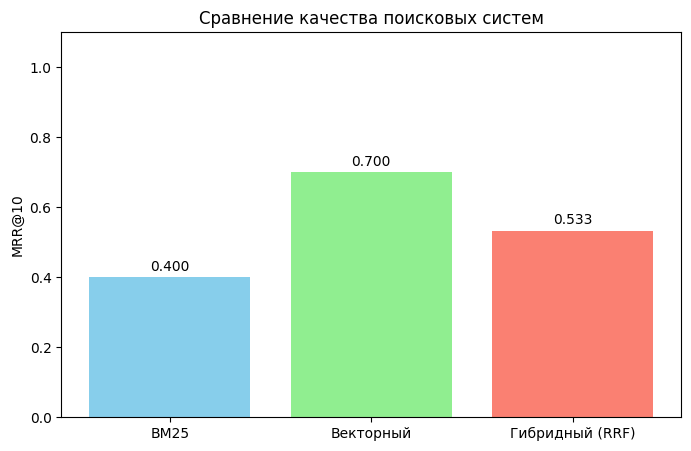

In [29]:
# Оборачиваем наши поисковики в функции нужного формата
def bm25_search_fn(query, top_k):
    return bm25.search(query, top_k=top_k)

def vector_search_fn(query, top_k):
    return vector_search.search(query, top_k=top_k)

def hybrid_search_fn(query, top_k):
    # Используем RRF для объективного сравнения (без alpha)
    hybrid = HybridSearch(bm25, vector_search, alpha=0.5)
    return hybrid.search(query, top_k=top_k, method='rrf')

# Рассчитываем MRR@10 для каждого метода
k = 10
bm25_mrr = calculate_mrr_at_k(bm25_search_fn, EVAL_QRELS, EVAL_QRELS, k)
vector_mrr = calculate_mrr_at_k(vector_search_fn, EVAL_QRELS, EVAL_QRELS, k)
hybrid_mrr = calculate_mrr_at_k(hybrid_search_fn, EVAL_QRELS, EVAL_QRELS, k)

# Выводим результаты
print(f"Результаты оценки качества (MRR@{k}):")
print(f"BM25:          {bm25_mrr:.4f}")
print(f"Векторный:     {vector_mrr:.4f}")
print(f"Гибридный(RRF):{hybrid_mrr:.4f}")

methods = ['BM25', 'Векторный', 'Гибридный (RRF)']
scores = [bm25_mrr, vector_mrr, hybrid_mrr]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('MRR@10')
plt.title('Сравнение качества поисковых систем')
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

plt.show()

In [30]:
text_to_id = {text: idx for idx, text in enumerate(documents)}
questions_df['doc_id'] = df['text'].map(text_to_id)
test_set = (
    questions_df.groupby('q')['doc_id']
    .apply(lambda x: list(set(x)))
    .reset_index()
    .rename(columns={'q': 'query', 'doc_id': 'relevant'})
    .to_dict(orient='records')
)

/var/folders/rd/skj0w1gx70v2_kz3x6xprx8h0000gn/T/ipykernel_77090/410394351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_df['doc_id'] = df['text'].map(text_to_id)
